# Post-processing of the axes

IDEA:
- take the data of the axes
- smooth it

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.interpolate import UnivariateSpline

In [2]:
VIDEO_NUMBER = "2"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "spin" / "intermediate_data" / f"Spin_data_{VIDEO_NUMBER}.csv")
INPUT_CENTER_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_raw_{VIDEO_NUMBER}.csv")

In [3]:
# Load data
df_spin = pd.read_csv(INPUT_CSV_PATH)
df_center = pd.read_csv(INPUT_CENTER_PATH)

# Convert to numeric
for col in ['pA_x', 'pA_y', 'pB_x', 'pB_y']:
    df_spin[col] = pd.to_numeric(df_spin[col], errors='coerce')

for col in ['x', 'y', 'radius']:
    df_center[col] = pd.to_numeric(df_center[col], errors='coerce')

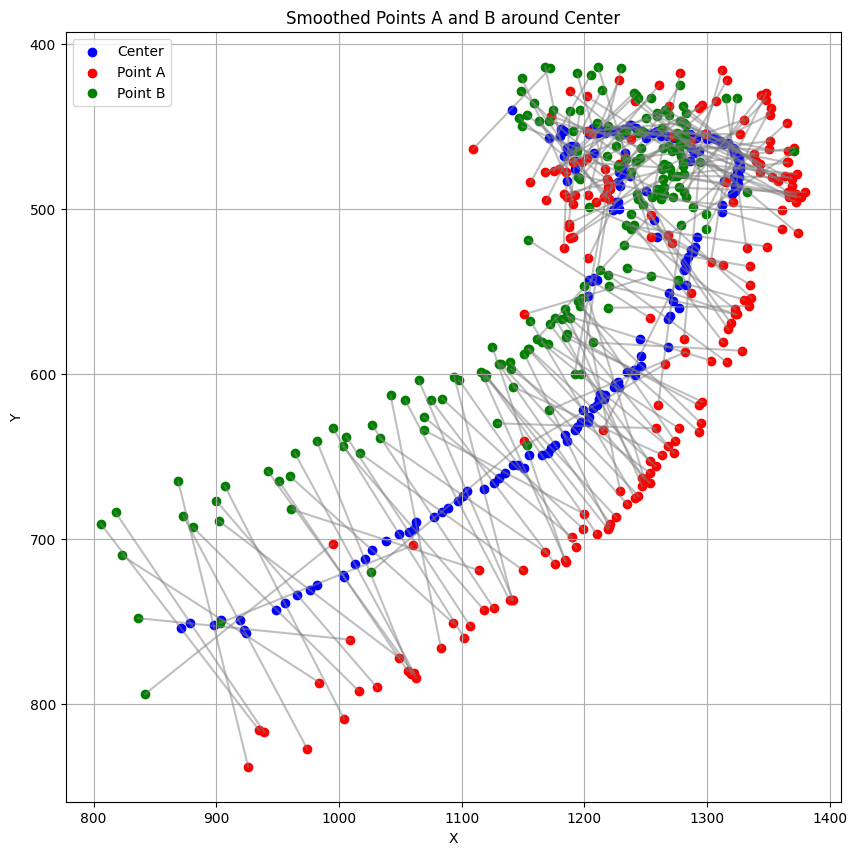

In [4]:
# Filter valid points for plotting
valid_plot_idx = df_spin[['pA_x', 'pA_y', 'pB_x', 'pB_y']].notna().all(axis=1)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(df_center.loc[valid_plot_idx, 'x'], df_center.loc[valid_plot_idx, 'y'], color='blue', label='Center')
plt.scatter(df_spin.loc[valid_plot_idx, 'pA_x'], df_spin.loc[valid_plot_idx, 'pA_y'], color='red', label='Point A')
plt.scatter(df_spin.loc[valid_plot_idx, 'pB_x'], df_spin.loc[valid_plot_idx, 'pB_y'], color='green', label='Point B')

# Optionally, draw lines between A and B to visualize orientation
for i in df_spin.index[valid_plot_idx]:
    plt.plot(
        [df_spin.loc[i, 'pA_x'], df_spin.loc[i, 'pB_x']],
        [df_spin.loc[i, 'pA_y'], df_spin.loc[i, 'pB_y']],
        color='gray', alpha=0.5
    )

plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()  # Invert y-axis if dealing with image coordinates
plt.title('Smoothed Points A and B around Center')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Convert coordinate columns to numeric
for c in ['pA_x','pA_y','pB_x','pB_y']:
    df_spin[c] = pd.to_numeric(df_spin[c], errors='coerce')

In [6]:
# Compute valid gradient
mask_valid = df_spin[['pA_x','pA_y','pB_x','pB_y']].notna().all(axis=1)
dx = df_spin['pB_x'] - df_spin['pA_x']
dy = df_spin['pB_y'] - df_spin['pA_y']
gradient = (dy / dx.replace({0: np.nan})).where(mask_valid)

In [7]:
# Remove outliers using rolling MAD
window_size = 11
mad_thresh = 3.0
rolling_med = gradient.rolling(window=window_size, center=True, min_periods=1).median()
rolling_mad = gradient.rolling(window=window_size, center=True, min_periods=1).apply(
    lambda x: np.median(np.abs(x - np.median(x))), raw=True
)
is_outlier = np.abs(gradient - rolling_med) > mad_thresh * rolling_mad
gradient_clean = gradient.mask(is_outlier)

In [8]:
# Fit a spline to cleaned data
valid_idx = gradient_clean.dropna().index
frames = df_spin.loc[valid_idx, 'frame'].values
values = gradient_clean.loc[valid_idx].values
spline = UnivariateSpline(frames, values, s=50)
xnew = np.linspace(frames.min(), frames.max(), 500)
ynew = spline(xnew)

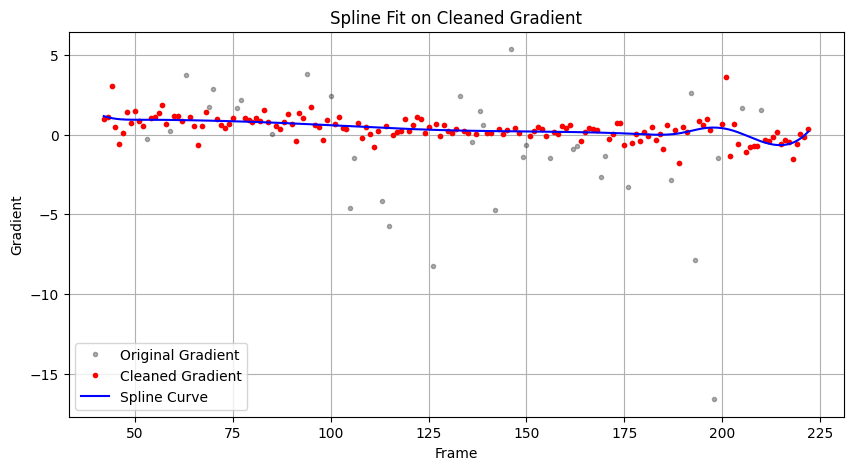

In [9]:
# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(df_spin['frame'], gradient, 'k.', alpha=0.3, label='Original Gradient')
plt.plot(df_spin['frame'], gradient_clean, 'r.', label='Cleaned Gradient')
plt.plot(xnew, ynew, 'b-', label='Spline Curve')
plt.xlabel('Frame')
plt.ylabel('Gradient')
plt.title('Spline Fit on Cleaned Gradient')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Save new coordinates
#output_path = PROJECT_ROOT / "notebook/spin/intermediate_data" / f"Spin_data_updated_{VIDEO_NUMBER}.csv"
#df_spin.to_csv(output_path, index=False)
#print(f"Updated coordinates saved to {output_path}")